### PLACE ALL IMPORTS HERE (easier to keep track of)

In [283]:
# general
from __future__ import division
from collections import defaultdict
from collections import Counter
import os
import random
import re

# to read in JSON character objects 
import json

# for stopwords
import nltk
from nltk.tokenize import RegexpTokenizer

# for LDA topic modeling
from gensim import corpora, models, similarities, matutils

# for lots of math junk and plotting
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# for making data frames
import pandas as pd
# for clustering, etc.
from sklearn import metrics
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import euclidean_distances

from scipy.cluster.hierarchy import ward, dendrogram
import scipy.stats as stats


# Read in character JSON, build feature vectors for a BOW-type model

Things to do: Fiddle with the mention threshold, dialogue features (to include or not to include?), maybe throw out the most common attributes afterward

**NOTE: All of this functionality is now located in the loadCharFeatures module**

In [284]:
import loadCharFeatures
(characters, character_namelists, total_features, top_n) = loadCharFeatures.getCharVectorsFromJson()

Most common words in book:  [('the', 47552.0), ('to', 26268.0), ('and', 25179.0), ('of', 21444.0), ('a', 19852.0), ('.', 17618.0), ('was', 15155.0), ('he', 14435.0), ('his', 13612.0), ('said', 12682.0), ('in', 11952.0), ('Harry', 11326.0), ('had', 9954.0), ('that', 8840.0), ('at', 8322.0), ('you', 8044.0), ('it', 7310.0), ('I', 7282.0), ('as', 7026.0), ('with', 6272.0), ('on', 6097.0), ('for', 5193.0), ('He', 4990.0), ('not', 4666.0), ('\xc2\x91', 4527.0), ('her', 4418.0), ('they', 4259.0), ('be', 4258.0), ('were', 4155.0), ('but', 4010.0), ('from', 3997.0), ('have', 3970.0), ('out', 3847.0), ('him', 3806.0), ('\xe2\x80\x94', 3561.0), ('she', 3462.0), ('up', 3432.0), ('into', 3427.0), ('Ron', 3366.0), ('all', 3336.0), ('The', 3250.0), ('been', 3136.0), ('Hermione', 3119.0), ('what', 2798.0), ('could', 2668.0), ('back', 2595.0), ('who', 2581.0), ('their', 2497.0), ('is', 2491.0), ('them', 2482.0), ('Harry,', 2400.0), ('\xe2\x80\x9cI', 2326.0), ('looked', 2321.0), ('about', 2282.0), ('so

**Create texts to feed to gensim, print out BOW for each character**

In [285]:
texts = [None for key in characters]
names = {}
i = 0
for key, value in characters.iteritems():
    print str(key) + ": " + str(value)
    texts[i] = value
    names[key] = i
    i += 1
    print
print len(characters)

Madam Rosmerta: [u'forc_PATIENT', u'gasp_PATIENT', u'breath_PATIENT', u'stare_AGENT', u'fill_AGENT', u'eject_wizard_AGENT', u'totter_AGENT', u'send_bottl_AGENT', u'have_oth_AGENT', u'tip_you_AGENT', u'help__AGENT', u'admit_AGENT', u'let_sigh_AGENT', u'abl_MOD', u'stay_SAY', u'black_SAY', u'area_SAY', u'minist_SAY', u'dementor_SAY', u'search_SAY', u'whole_SAY', u'villag_SAY', u'twjce_SAY', u'worst_SAY', u'wors_SAY', u'murder_SAY', u'poor_SAY', u'mean_SAY', u'natur_SAY', u'black_SAY', u'leagu_SAY', u'doe_SAY', u'work_SAY', u'black_SAY', u'potter_SAY', u'secret-keep_SAY', u'suspect_SAY', u'black_SAY', u'black_SAY', u'betray_SAY', u'manag_SAY', u'disappear_SAY', u'ministri_SAY', u'magic_SAY', u'caught_SAY', u'next_SAY', u'day_SAY', u'pettigrew_SAY', u'fat_SAY', u'boy_SAY', u'alway_SAY', u'tag_SAY', u'hogwart_SAY', u'black_SAY', u'taken_SAY', u'twenti_SAY', u'member_SAY', u'magic_SAY', u'law_SAY', u'enforc_SAY', u'squad_SAY', u'pettigrew_SAY', u'receiv_SAY', u'order_SAY', u'merlin_SAY', u'c

**Print most common features (to do: maybe filter these out of the model?)**

In [286]:
counter = Counter(total_features)
top_n = counter.most_common(20)
print top_n
print

for text in texts:
    for word_tupe in top_n:
        while word_tupe[0] in text:
            text.remove(word_tupe[0])
#print texts

[(u'oh_SAY', 397.0), (u'yes_SAY', 360.0), (u'stare_AGENT', 334.0), (u'yeah_SAY', 308.0), (u'potter_SAY', 296.0), (u'shoulder_POSS', 269.0), (u'good_SAY', 268.0), (u'stood_AGENT', 257.0), (u'tell__AGENT', 257.0), (u'walk_AGENT', 255.0), (u'sat_AGENT', 250.0), (u'whi_SAY', 249.0), (u'robe_POSS', 245.0), (u'hair_POSS', 219.0), (u'mean_SAY', 218.0), (u'thing_SAY', 211.0), (u'ear_POSS', 210.0), (u'mind_POSS', 205.0), (u'cours_SAY', 205.0), (u'doe_SAY', 196.0)]



## Do LDA Topic Modeling Using Character Features

In [287]:
# create Gensim dictionary from the texts
dictionary = corpora.Dictionary(texts)

# create bag of words model to perform analysis
corpus = [dictionary.doc2bow(text) for text in texts]

numtopics = 12

lda = models.LdaModel(corpus, num_topics=numtopics, 
                            id2word=dictionary, 
                            update_every=5, 
                            chunksize=100, 
                            passes=100)


The following commented code is an attempt to determine the optimal number of clusters using the Arun, et al. measure. Implementation credit goes to Christopher Grainger (http://blog.cigrainger.com/2014/07/lda-number.html). However, we are not using it at this time because it takes too long/too much memory to run and doesn't necessarily produce good results.

In [288]:
# Define KL function
# def sym_kl(p,q):
#     return np.sum([stats.entropy(p,q),stats.entropy(q,p)])

# l = np.array([sum(cnt for _, cnt in doc) for doc in corpus])
# def arun(corpus,dictionary,min_topics=1,max_topics=50,step=3):
#     kl = []
#     for i in range(min_topics,max_topics,step):
#         print i
#         lda = models.LdaModel(corpus=corpus,
#             id2word=dictionary,num_topics=i,passes=20)
#         m1 = lda.expElogbeta
#         U,cm1,V = np.linalg.svd(m1)
#         #Document-topic matrix
#         lda_topics = lda[corpus]
#         m2 = matutils.corpus2dense(lda_topics, lda.num_topics).transpose()
#         cm2 = l.dot(m2)
#         cm2 = cm2 + 0.0001
#         cm2norm = np.linalg.norm(l)
#         cm2 = cm2/cm2norm
#         kl.append(sym_kl(cm1,cm2))
#     return kl
    
# kl = arun(corpus,dictionary)
# # Plot kl divergence against number of topics
# plt.plot(kl)
# plt.ylabel('Symmetric KL Divergence')
# plt.xlabel('Number of Topics')
# plt.savefig('kldiv.png', bbox_inches='tight')

In [289]:
print(lda.show_topics())

[u'0.005*smile_AGENT + 0.004*offic_POSS + 0.003*lord_SAY + 0.003*desk_POSS + 0.003*magic_SAY + 0.003*wizard_SAY + 0.003*continu_AGENT + 0.003*sure_SAY + 0.003*hogwart_SAY + 0.003*need_SAY', u'0.006*dobbi_SAY + 0.006*sir_SAY + 0.005*son_POSS + 0.003*heir_POSS + 0.002*do_it_AGENT + 0.002*father_SAY + 0.002*appear_AGENT + 0.002*magic_SAY + 0.002*master_SAY + 0.002*wizard_SAY', u'0.009*master_SAY + 0.009*kreacher_SAY + 0.003*visit_PATIENT + 0.003*regulus_SAY + 0.003*tale_POSS + 0.003*diggori_SAY + 0.002*fight_SAY + 0.002*croak_PATIENT + 0.002*call_SAY + 0.002*squeak_PATIENT', u'0.006*mother_POSS + 0.003*escap_AGENT + 0.003*gang_POSS + 0.002*letter_POSS + 0.002*parent_POSS + 0.002*black_SAY + 0.002*hous_POSS + 0.002*father_POSS + 0.002*gone_AGENT + 0.002*godfath_POSS', u'0.003*daddi_SAY + 0.002*hous_POSS + 0.002*meet_SAY + 0.002*room_POSS + 0.002*girlfriend_POSS + 0.002*pull_PATIENT + 0.002*father_POSS + 0.002*dodge__AGENT + 0.002*call_AGENT + 0.002*leav_PATIENT', u'0.003*bag_POSS + 0.003*n

#### Print top n words for each topic

Word Clouds for each topic generated using the wordcloud package - use "pip install wordcloud" (http://peekaboo-vision.blogspot.de/2012/11/a-wordcloud-in-python.html)

Topic  0
mother_POSS escap_AGENT gang_POSS letter_POSS parent_POSS black_SAY hous_POSS father_POSS gone_AGENT godfath_POSS tongu_POSS bit_SAY crouch_SAY appear_AGENT sit_AGENT chair_POSS friend_POSS stand_AGENT remus_SAY kill_SAY group_SAY ministri_SAY room_POSS die_AGENT mother_SAY hit_PATIENT cackl_AGENT dad_SAY big_SAY do_it_AGENT 


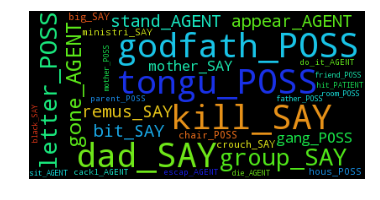

Topic  1
dear_SAY arthur_SAY call_AGENT husband_POSS son_POSS suppos_SAY follow_PATIENT worri_SAY ginni_SAY thank_SAY sob_AGENT lip_POSS ad_AGENT better_SAY snap_AGENT father_SAY enough_SAY hesit_AGENT bed_SAY sure_SAY day_SAY hurri_AGENT ran_AGENT sit_AGENT mum_SAY gaze_AGENT happen_SAY ministri_SAY jump_AGENT bit_SAY 


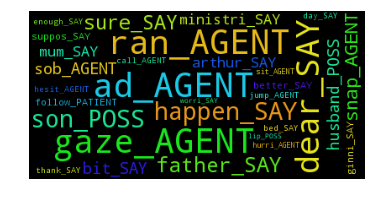

Topic  2
desk_POSS offic_POSS follow_PATIENT eyebrow_POSS strode_AGENT glass_POSS gryffindor_SAY spectacl_POSS hat_POSS say_what_AGENT montagu_SAY continu_AGENT student_SAY hogwart_SAY ad_AGENT miss_SAY keep_SAY glanc_AGENT leav_SAY dear_SAY move_AGENT slytherin_SAY hous_SAY magic_SAY quaffl_SAY bludger_SAY anoth_SAY sit_AGENT bell_SAY wait_AGENT 


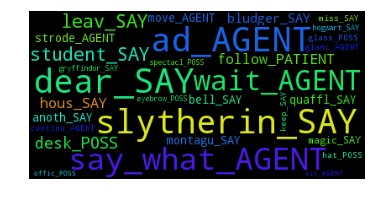

Topic  3
bag_POSS need_SAY anyth_SAY scream_AGENT dark_SAY suppos_SAY talk_SAY sit_AGENT year_SAY ministri_SAY ad_AGENT anyon_SAY happen_SAY began_AGENT stand_AGENT stop_SAY keep_SAY lip_POSS snap_AGENT stop_AGENT sure_SAY better_SAY bit_SAY laugh_AGENT mayb_SAY gasp_AGENT work_SAY move_AGENT umbridg_SAY school_SAY 


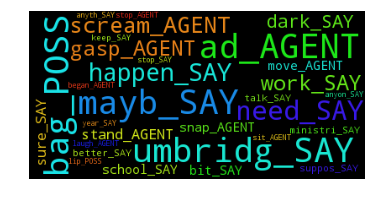

Topic  4
dobbi_SAY sir_SAY son_POSS heir_POSS do_it_AGENT father_SAY appear_AGENT magic_SAY master_SAY wizard_SAY winki_SAY squeak_PATIENT move_AGENT start_AGENT father_POSS grave_POSS live_AGENT brother_POSS set_PATIENT stick_POSS do_what_AGENT mother_POSS inform_SAY mr._SAY law_SAY boy_SAY wife_POSS squeak_AGENT vanish_AGENT shake_head_AGENT 


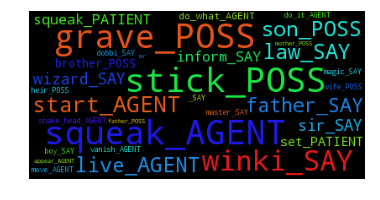

Topic  5
sure_MOD heart_POSS scar_POSS feel_AGENT glanc_AGENT realiz_AGENT stomach_POSS wonder_AGENT found_AGENT bed_POSS chest_POSS move_AGENT glass_POSS ask__AGENT forehead_POSS start_AGENT watch_PATIENT trunk_POSS knee_POSS notic_AGENT throat_POSS life_POSS pocket_POSS er_SAY watch_AGENT hurri_AGENT father_POSS need_SAY kill_SAY okay_SAY 


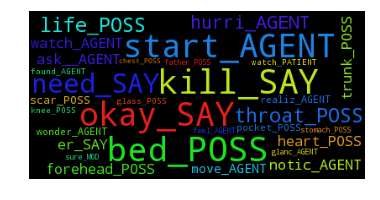

Topic  6
offic_POSS cage_POSS clipboard_POSS desk_POSS smile_POSS ad_AGENT handbag_POSS sure_SAY sister_POSS book_POSS stand_AGENT quill_POSS magic_SAY hem_SAY need_SAY ministri_SAY talk_AGENT watch_PATIENT dear_SAY eyebrow_POSS scoop_POSS ze_SAY ought_SAY bag_POSS abl_MOD sit_AGENT articl_POSS meet_SAY gone_AGENT smile_AGENT 


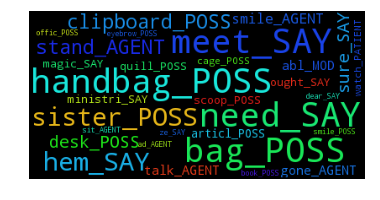

Topic  7
return_AGENT name_POSS growl_PATIENT kill_PATIENT support_POSS soul_POSS raise_wand_AGENT growl_AGENT year_SAY move_AGENT offic_POSS cloak_POSS scream_AGENT horcrux_POSS stop_PATIENT do_what_AGENT father_POSS need_AGENT call_PATIENT kept_AGENT master_SAY die_AGENT power_POSS death_SAY realiz_AGENT expect_AGENT scar_POSS continu_AGENT found_PATIENT say_what_AGENT 


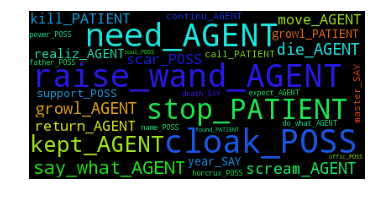

Topic  8
daddi_SAY hous_POSS meet_SAY room_POSS girlfriend_POSS pull_PATIENT father_POSS dodge__AGENT call_AGENT leav_PATIENT turn_ey_AGENT moment_SAY find_SAY friend_SAY snorkack_SAY car_POSS hat_POSS kill_PATIENT howev_SAY rememb_AGENT hurri_AGENT year_SAY hous_SAY rope_POSS crumple-horn_SAY hermi_SAY horn_SAY pleas_SAY smile_AGENT side_POSS 


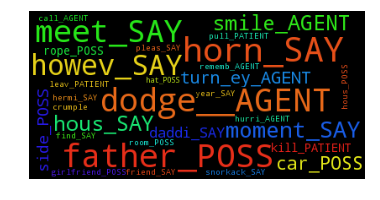

Topic  9
smile_AGENT offic_POSS lord_SAY desk_POSS magic_SAY wizard_SAY continu_AGENT sure_SAY hogwart_SAY need_SAY school_SAY dementor_SAY ad_AGENT year_SAY find_SAY dark_SAY armi_POSS happen_SAY ministri_SAY tonight_SAY cloak_POSS glass_POSS give_SAY death_SAY severus_SAY pocket_POSS return_SAY die_AGENT sirius_SAY pleas_SAY 


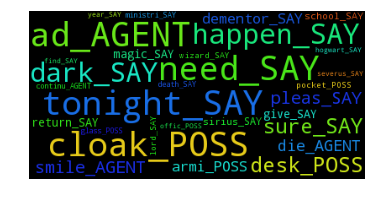

Topic  10
master_SAY kreacher_SAY visit_PATIENT regulus_SAY tale_POSS diggori_SAY fight_SAY croak_PATIENT call_SAY squeak_PATIENT cauldron_POSS pass_PATIENT order_SAY sit_AGENT happen_SAY lord_SAY turban_POSS mudblood_SAY return_AGENT gone_AGENT tell_i_AGENT spell_POSS shake_head_AGENT mistress_POSS everyth_SAY mother_SAY dark_SAY class_POSS open_mouth_AGENT bow_AGENT 


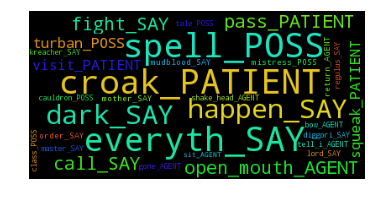

Topic  11
yeh_SAY ter_SAY bit_SAY ad_AGENT ask__AGENT stand_AGENT sit_AGENT cabin_POSS give_SAY start_AGENT offic_POSS move_AGENT year_SAY pocket_POSS magic_SAY stop_AGENT o_SAY hogwart_SAY dark_SAY find_SAY mum_SAY mind_SAY anyth_SAY need_SAY d'you_SAY talk_SAY hurri_AGENT chair_POSS sure_SAY work_SAY 


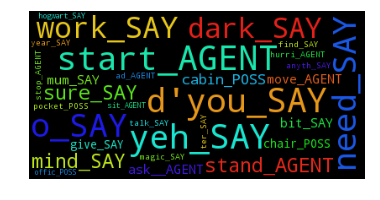

In [290]:
from wordcloud import WordCloud

%matplotlib inline
top_texts = []
for i in range(0, numtopics):
    print 'Topic ', i
    text = ""
    word_tups = lda.show_topic(i, 30)
    for tup in word_tups:
        scale = (int)(tup[0]*100 + 1)
        for i in range(scale):
            text += (tup[1])
            text += " "
    print text
    img = WordCloud(max_font_size=40, relative_scaling=.1).generate(text)
    # Display the generated image:
    plt.imshow(img)
    plt.axis("off")
    plt.show()


#### Create topic matrix (dimensions num_characters x num_topics) containing topic probabilities for each character

In [291]:
topic_matrix = [[0 for i in range(numtopics)] for namekey in names]
print len(topic_matrix)
i = 0
for namekey in names:
    print i, str(namekey) + " topic distribution: "
    for (key, value) in lda[corpus[names[namekey]]]:
        topic_matrix[i][key] = value
    i+=1
    print lda[corpus[names[namekey]]]

135
0 Madam Rosmerta topic distribution: 
[(0, 0.98793832405574455)]
1 Fang topic distribution: 
[(11, 0.99236096626224291)]
2 Hogsmeade topic distribution: 
[(10, 0.92361069395104201)]
3 Lupin topic distribution: 
[(9, 0.99898145809104844)]
4 Dudley topic distribution: 
[(0, 0.99823714811066544)]
5 Cho topic distribution: 
[(5, 0.99493542419270165)]
6 Roger Davies topic distribution: 
[(8, 0.97042964853878344)]
7 Dolohov topic distribution: 
[(1, 0.96333237107670755)]
8 Madam Hooch topic distribution: 
[(7, 0.98970010205439174)]
9 Nicolas Flamel topic distribution: 
[(5, 0.96333187742357451)]
10 Lavender Brown topic distribution: 
[(0, 0.98129201867499261)]
11 Bertha Jorkins topic distribution: 
[(3, 0.98589710450722567)]
12 Fred topic distribution: 
[(11, 0.99915278383300932)]
13 Montague topic distribution: 
[(7, 0.94270740056084312)]
14 Marietta topic distribution: 
[(3, 0.60266024039161847), (7, 0.38411184623150796)]
15 Rufus Scrimgeour topic distribution: 
[(7, 0.9776417159374096

#### Bar plot visualization of above character topic probabilities

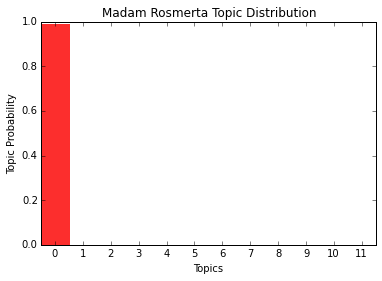

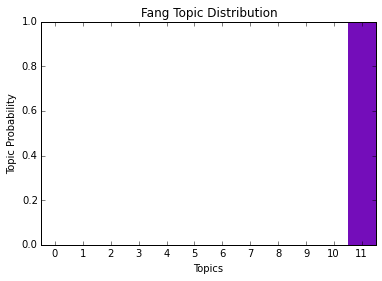

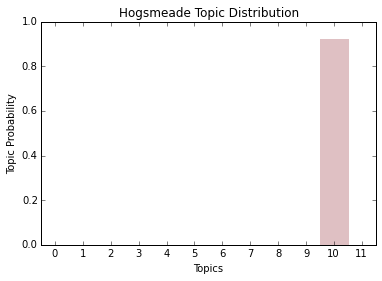

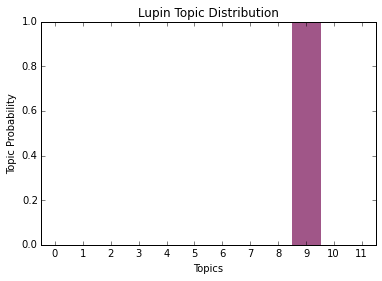

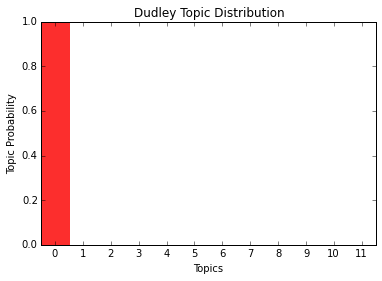

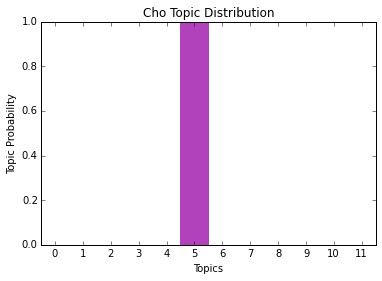

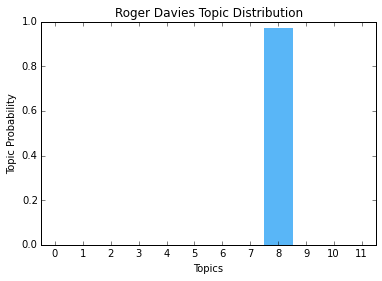

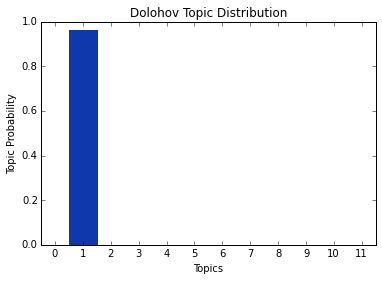

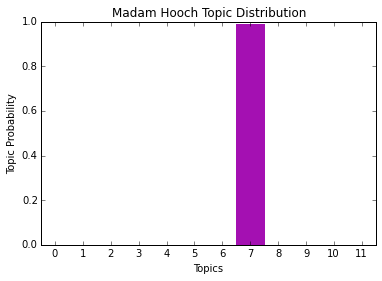

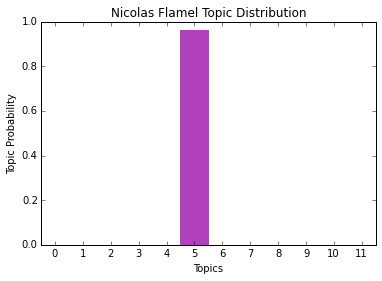

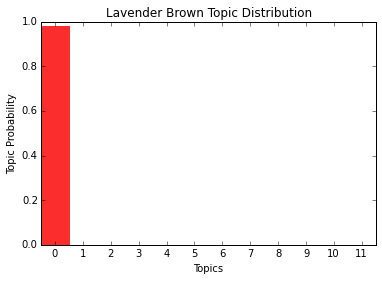

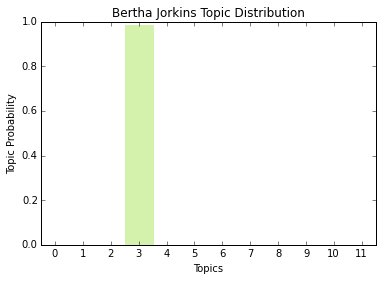

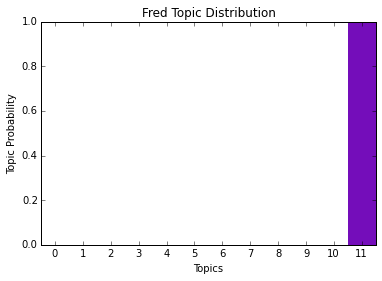

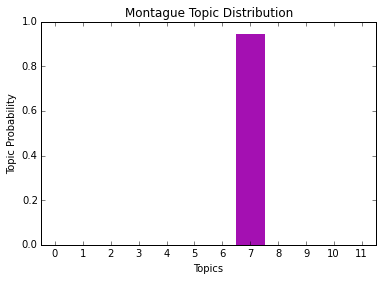

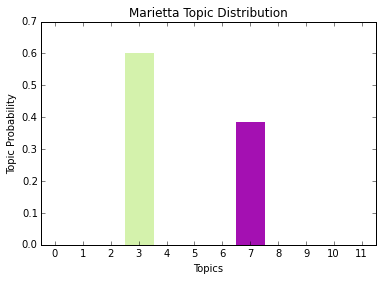

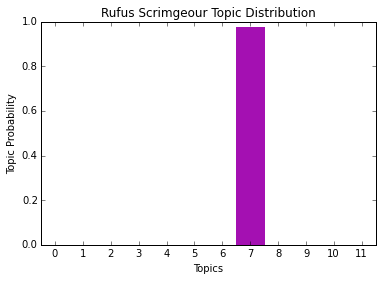

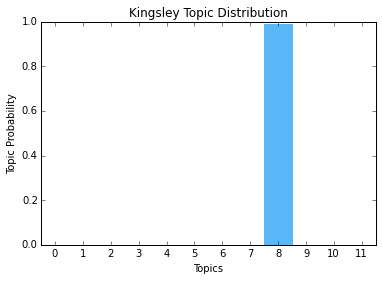

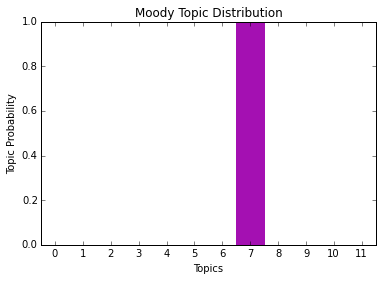

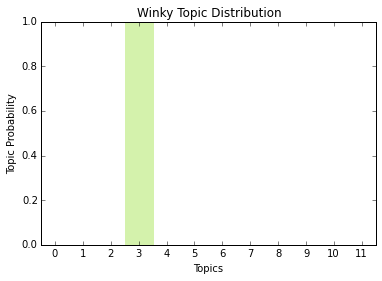

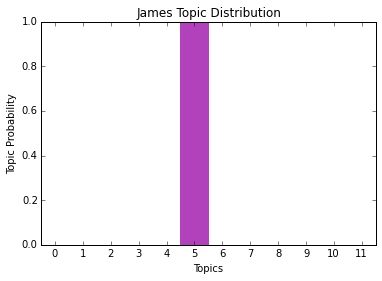

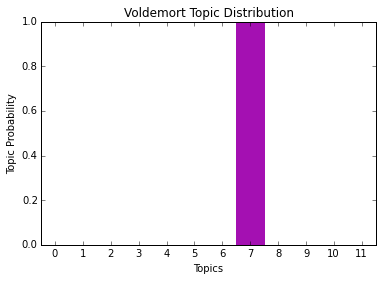

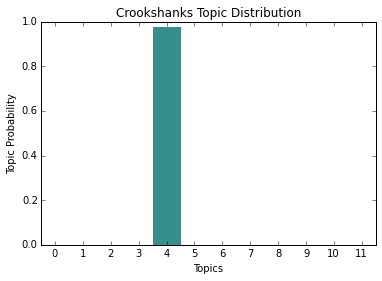

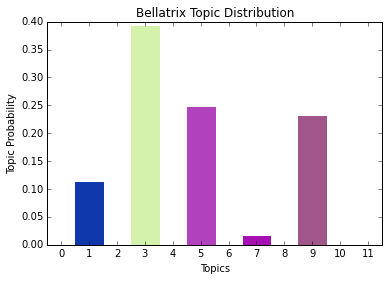

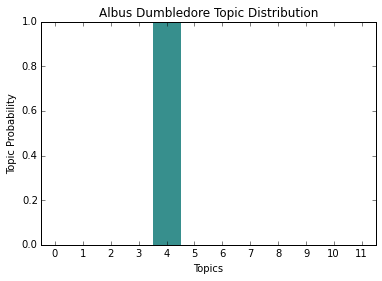

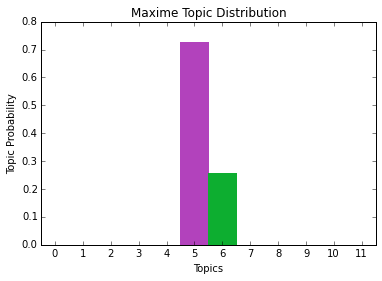

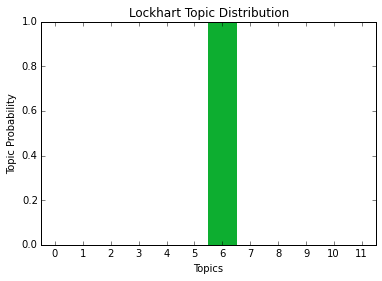

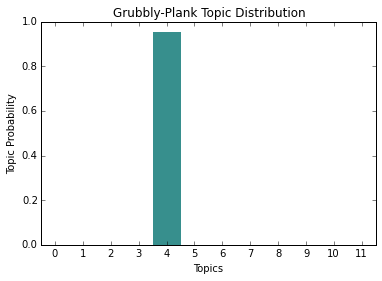

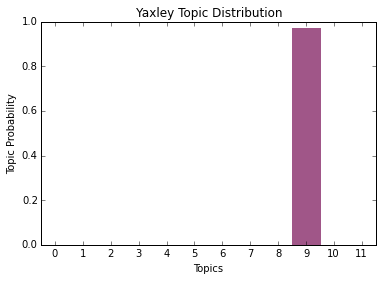

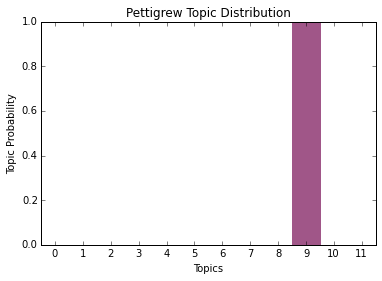

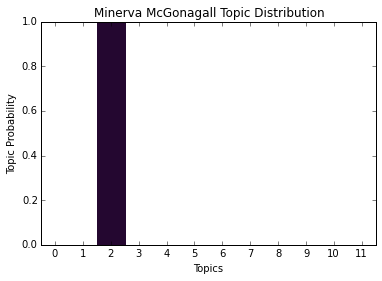

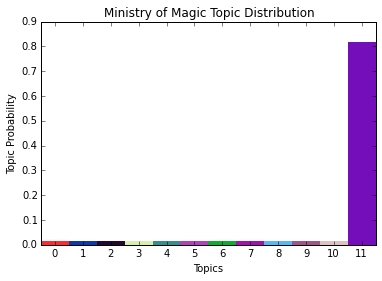

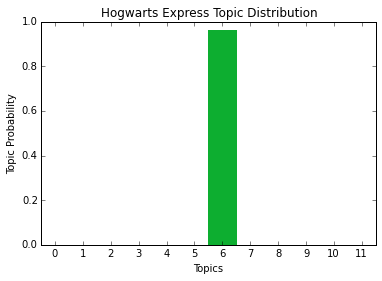

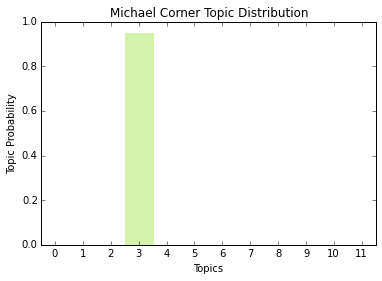

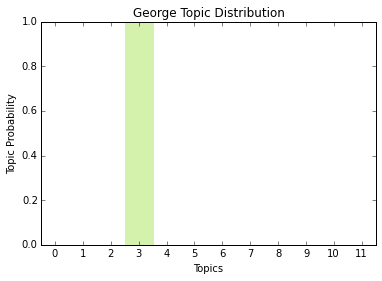

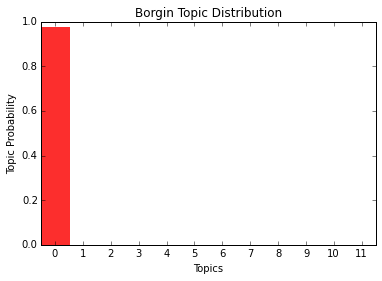

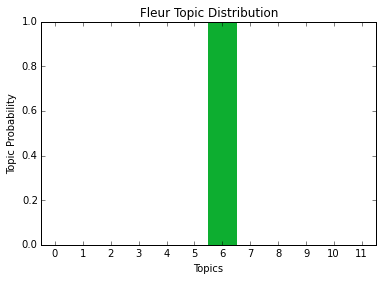

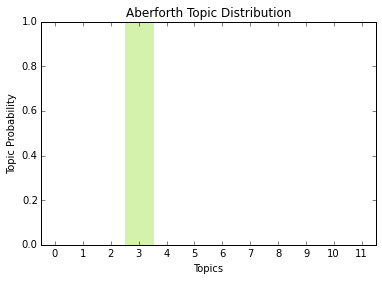

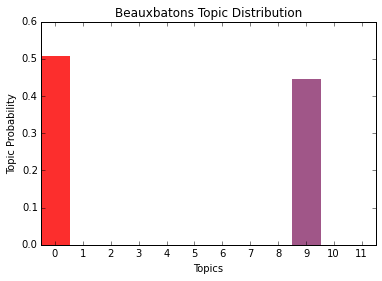

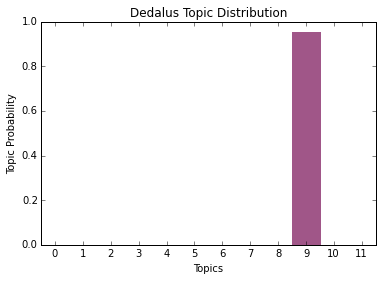

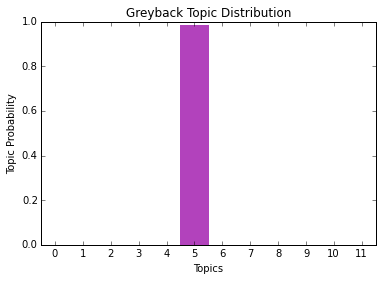

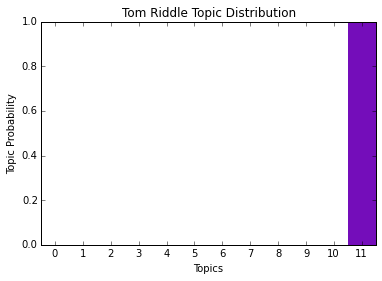

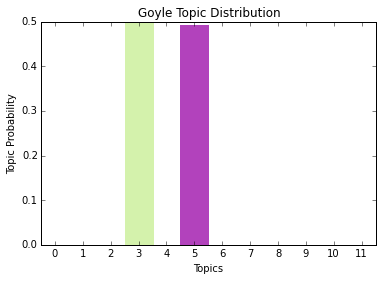

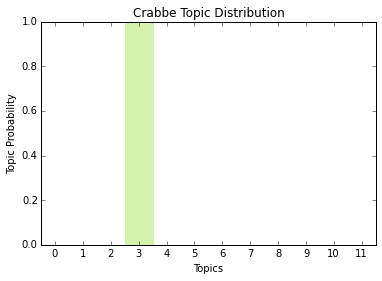

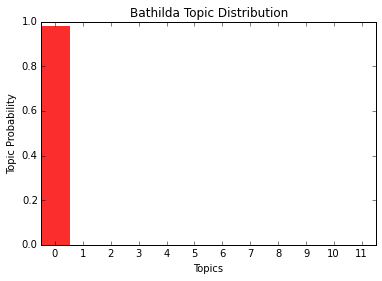

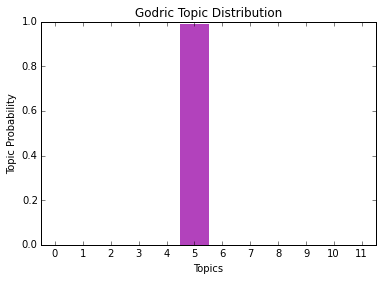

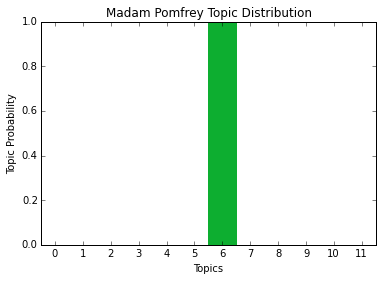

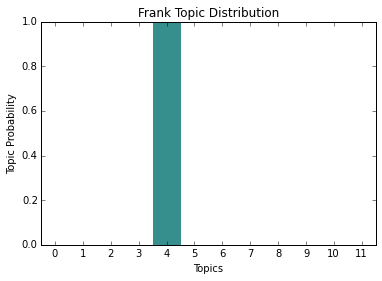

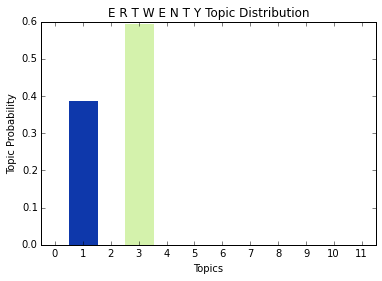

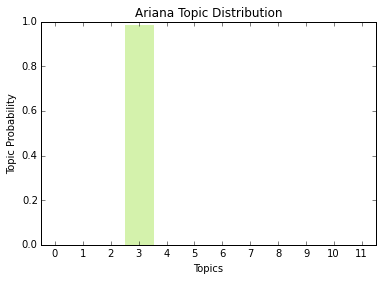

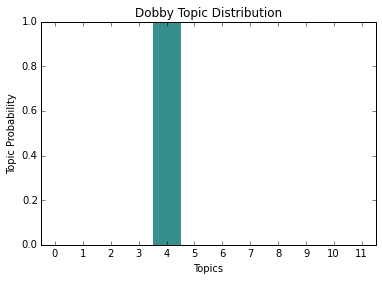

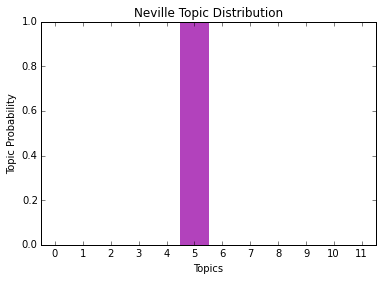

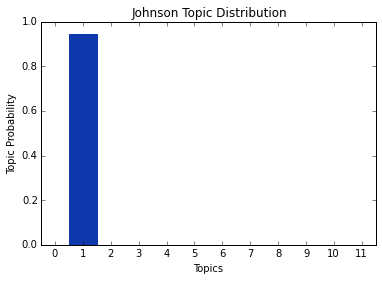

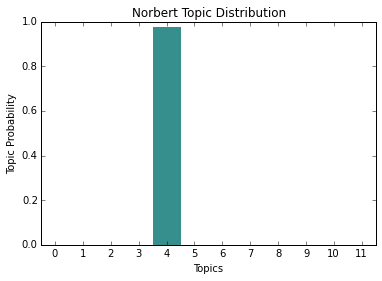

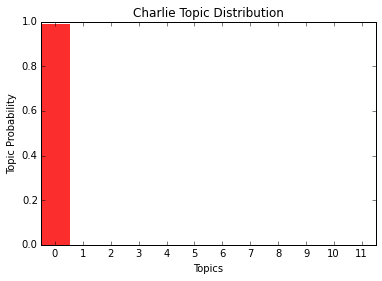

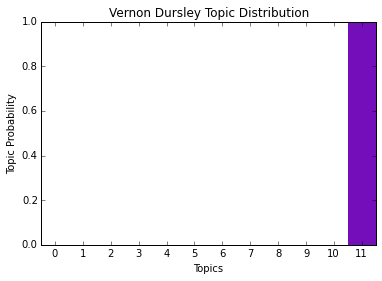

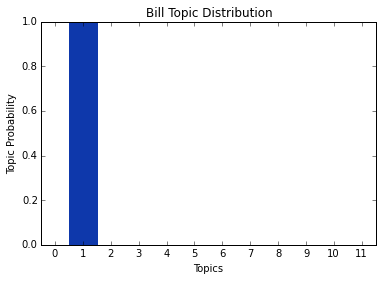

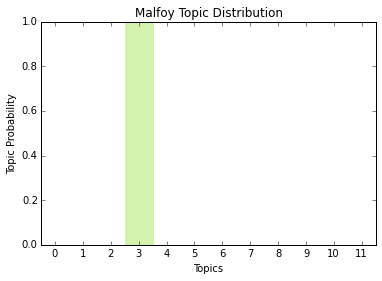

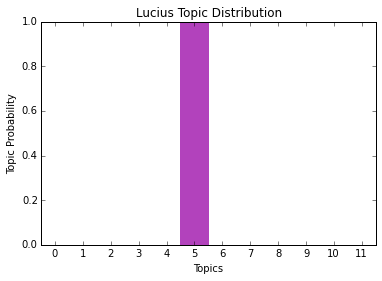

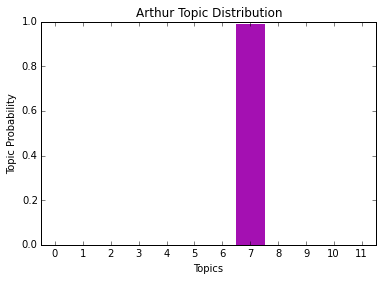

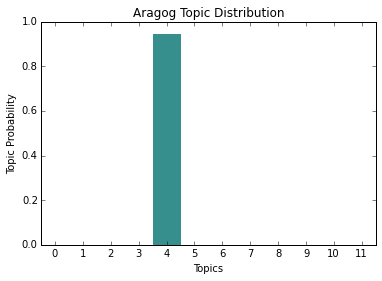

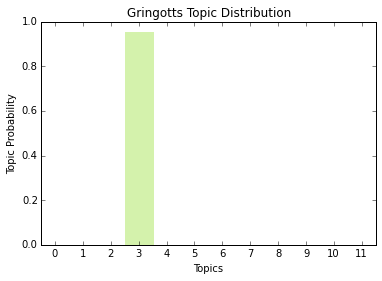

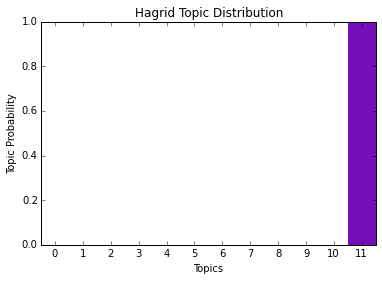

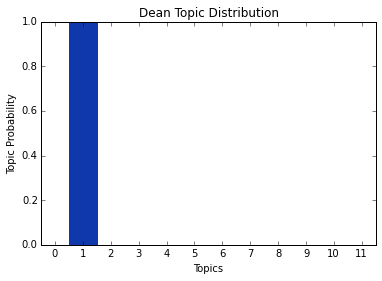

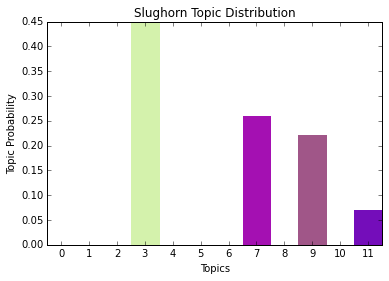

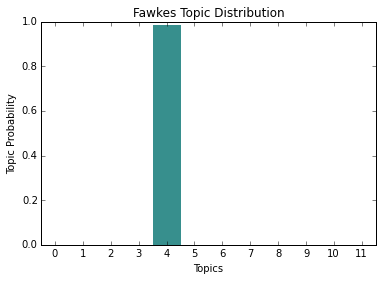

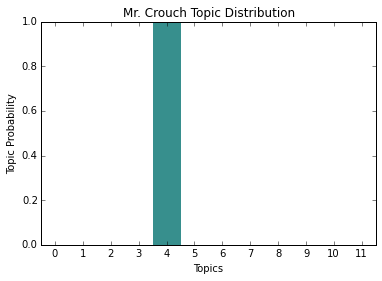

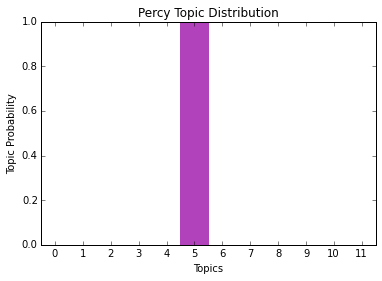

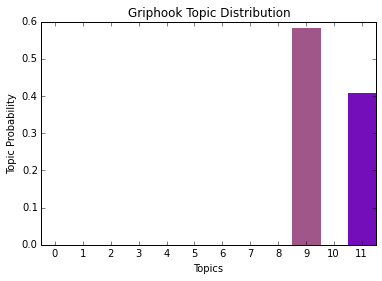

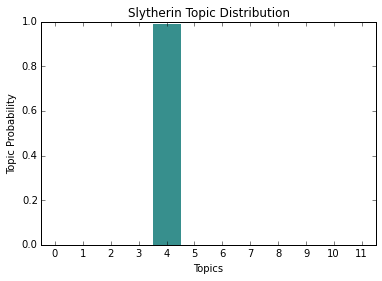

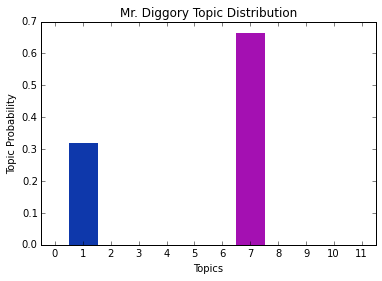

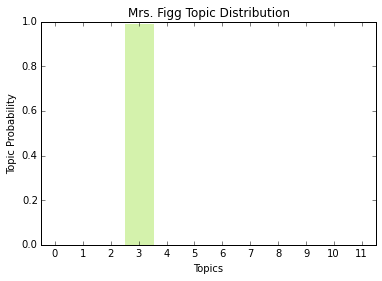

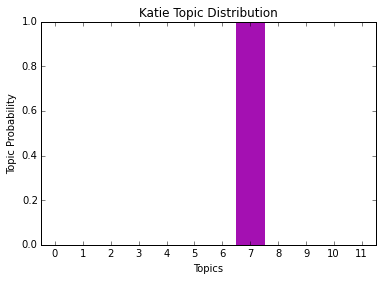

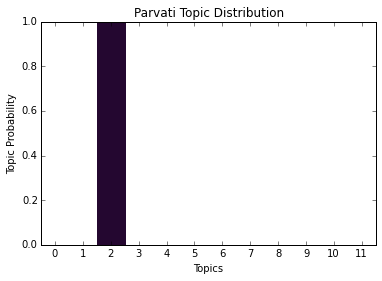

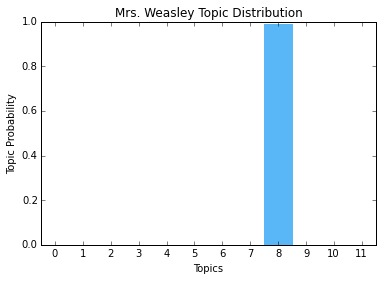

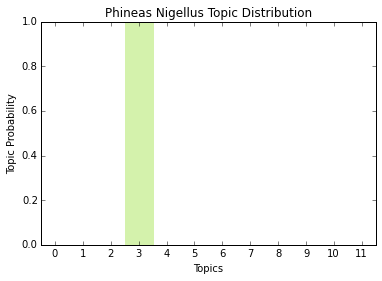

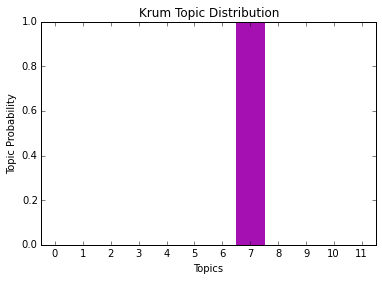

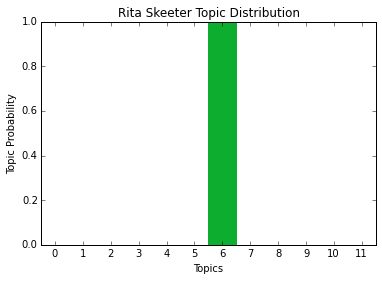

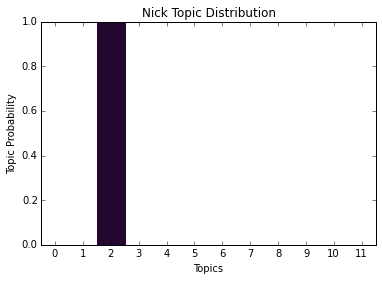

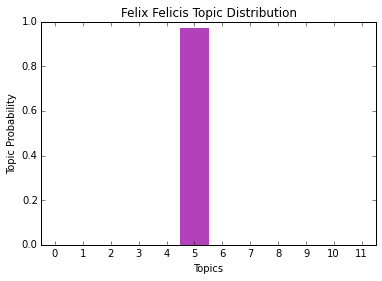

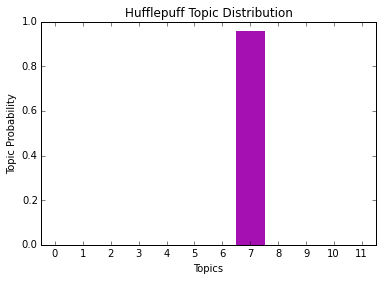

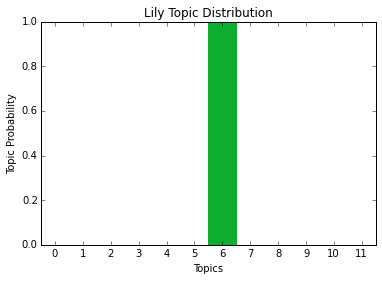

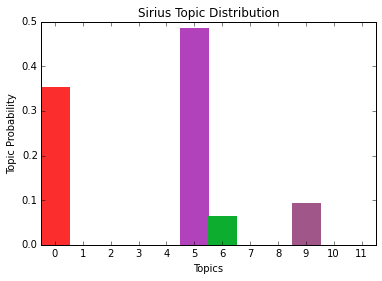

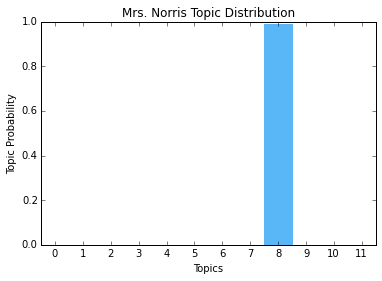

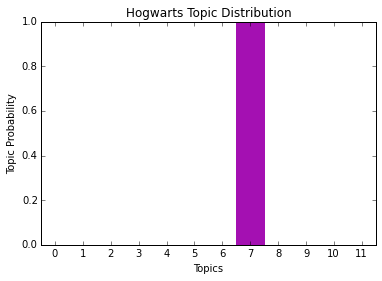

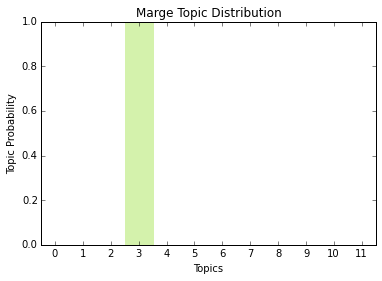

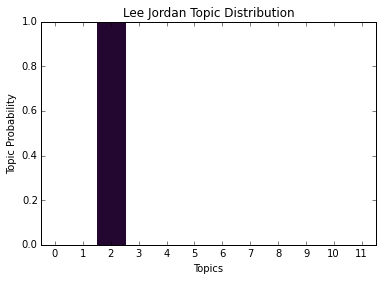

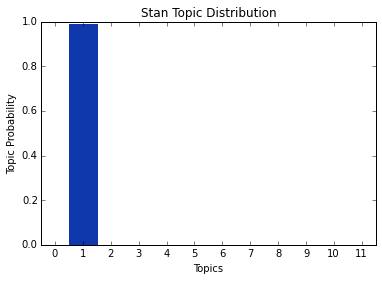

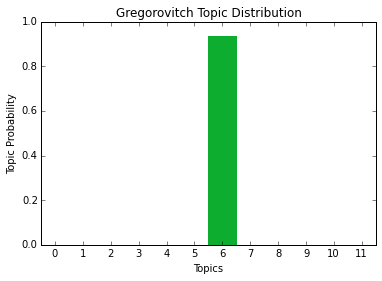

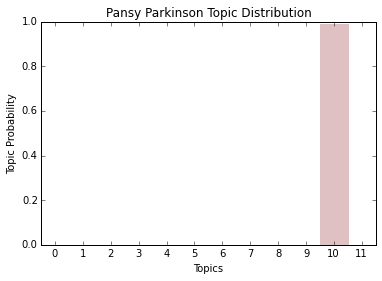

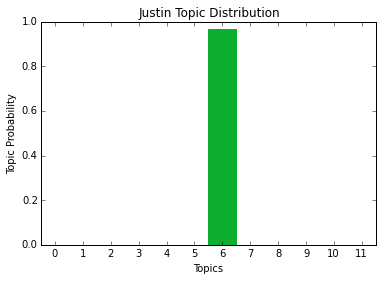

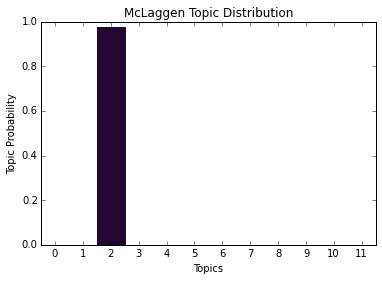

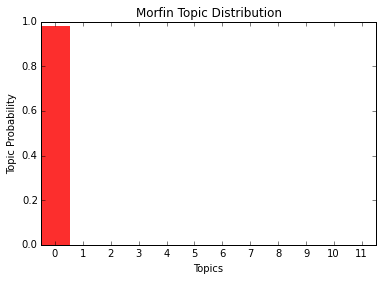

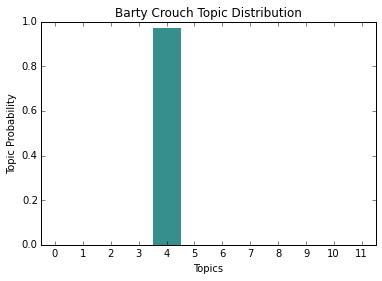

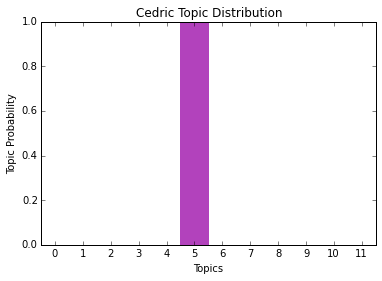

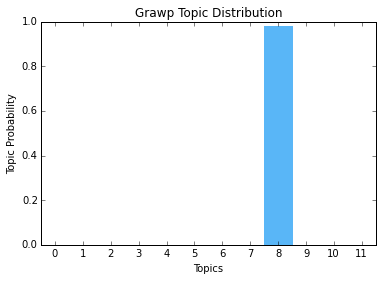

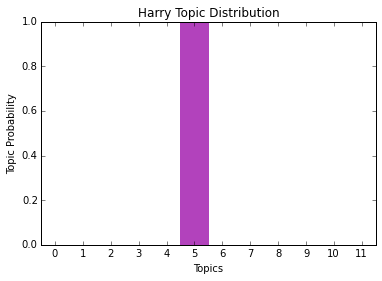

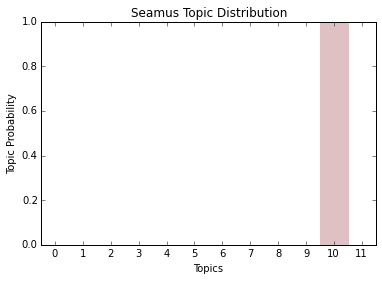

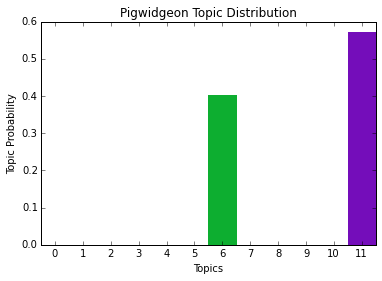

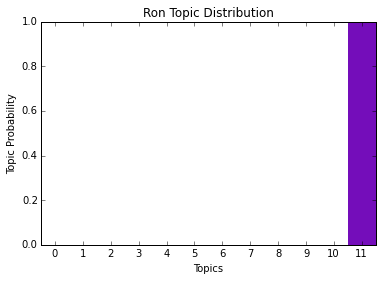

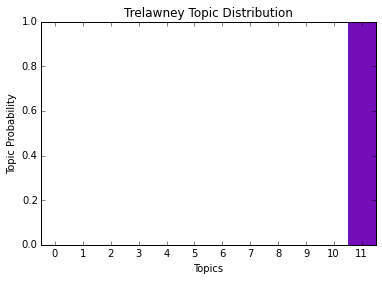

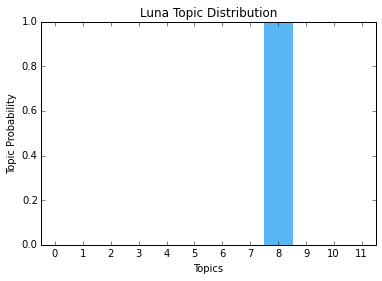

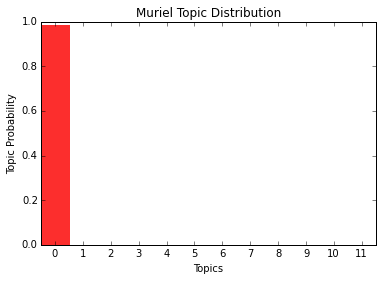

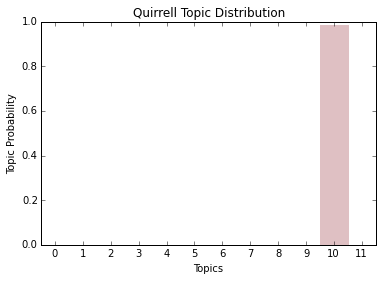

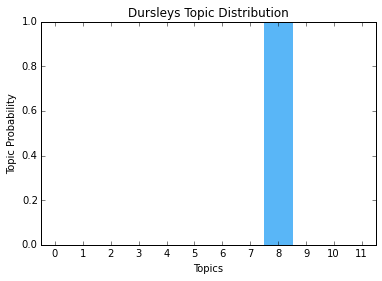

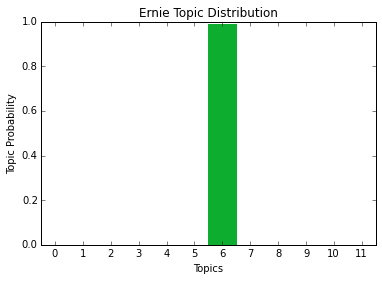

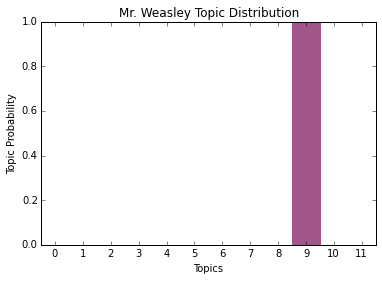

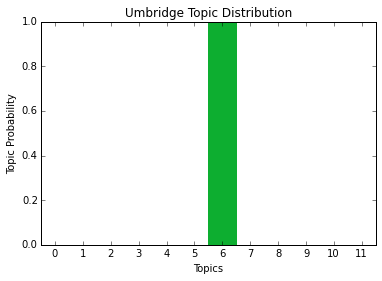

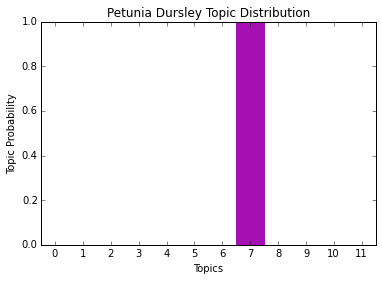

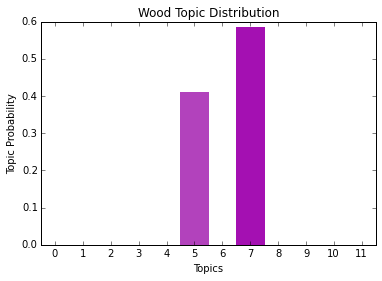

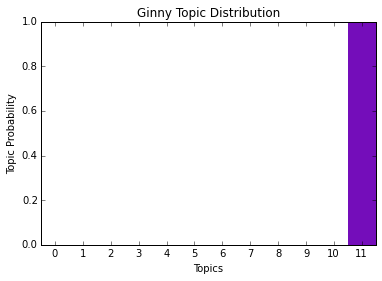

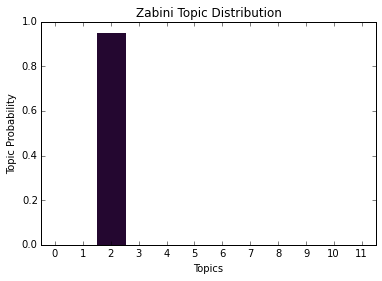

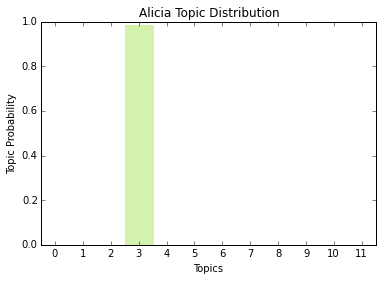

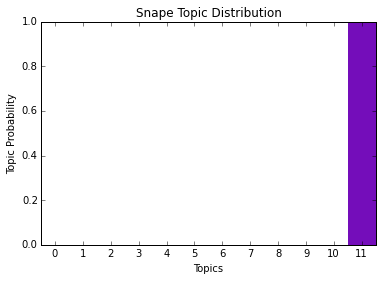

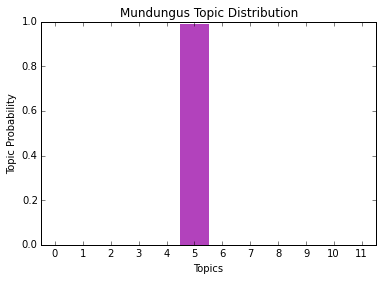

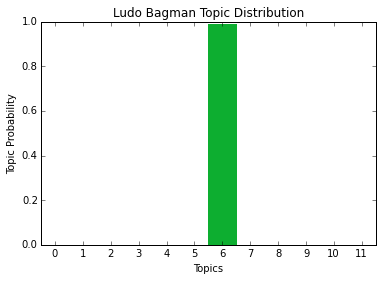

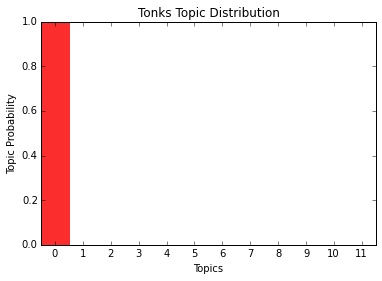

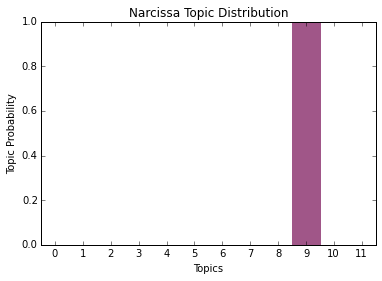

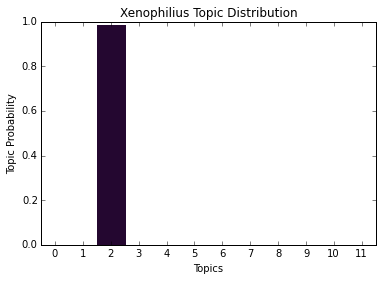

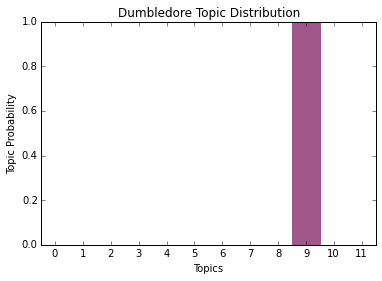

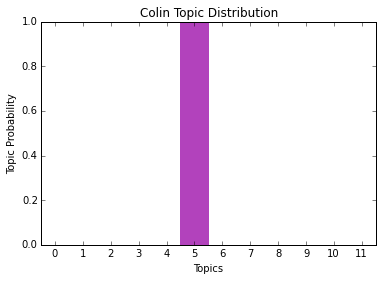

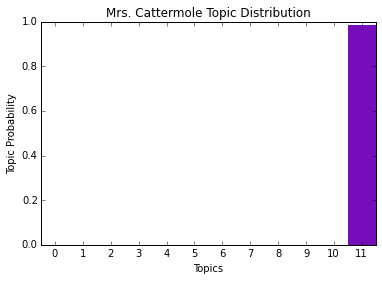

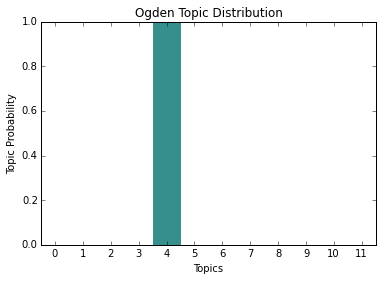

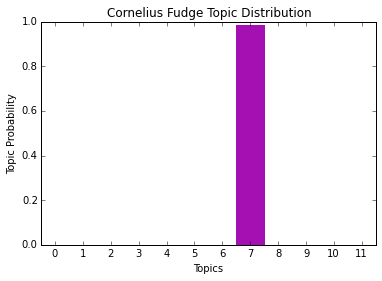

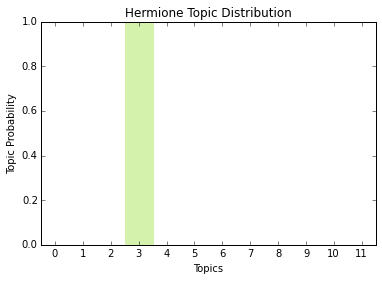

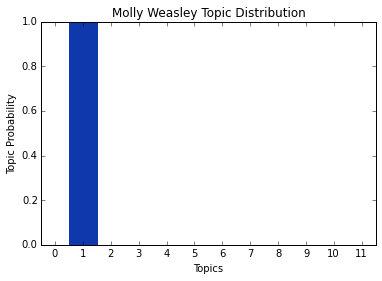

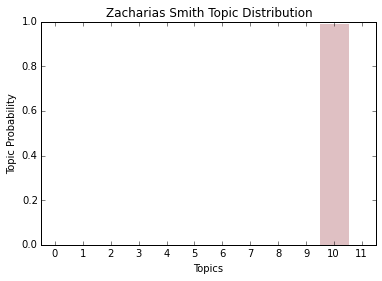

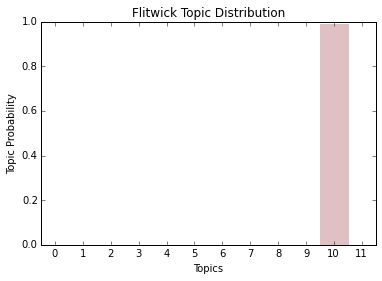

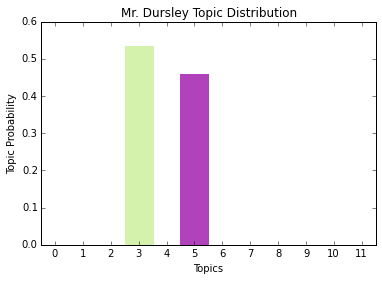

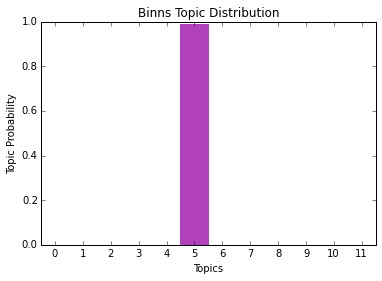

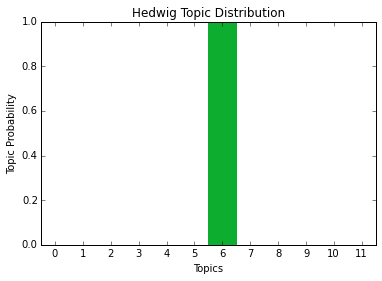

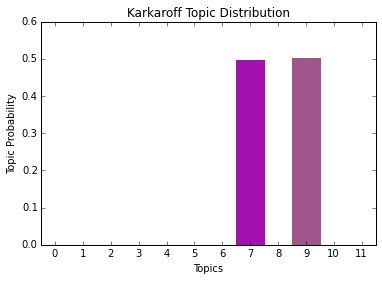

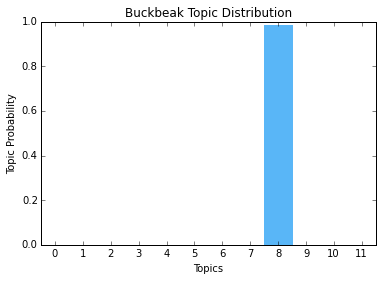

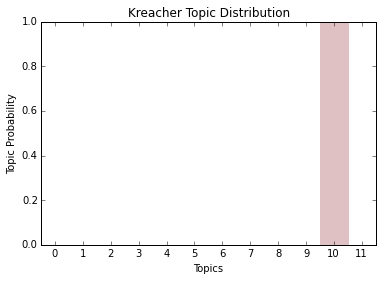

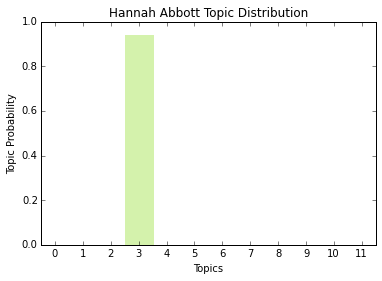

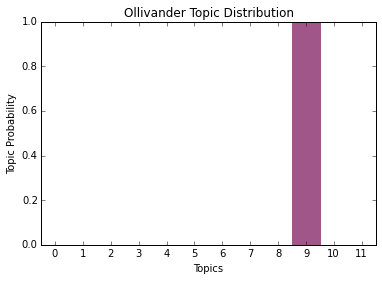

In [292]:
# Plot bar charts for each character's topics

# choose some random colors to represent each topic
topicColors = []
for i in range(numtopics):
    r = lambda: random.randint(0,255)
    color = '#%02X%02X%02X' % (r(),r(),r())
    topicColors.append(color)

%matplotlib inline 

# iterate through the character topic vectors, making a plot for each
nameit = names.iterkeys()
for charArray in topic_matrix:
    ind = np.arange(len(charArray))  # the x locations for the topics
    fig, ax = plt.subplots()
    width = 1
    
    topicNames = []
    topicProbs = []
    for i in range(len(charArray)):
        topicNames.append(i)
    
    rects1 = ax.bar(ind, charArray, width)
    for i in range(len(charArray)):
        rects1[i].set_color(topicColors[topicNames[i]])
        
    # add some text for labels, title and axes ticks
    ax.set_ylabel('Topic Probability')
    ax.set_xlabel('Topics')
    title =  nameit.next() + ' Topic Distribution'
    ax.set_title(title)
    ax.set_xticks(ind + width/2)
    ax.set_xticklabels(topicNames)
    plt.show()


## Perform Clustering Based on Character Topic Vectors

#### Use KMeans (is this the best choice?) and print out the clusters list

In [293]:
data = np.array(topic_matrix)

from sklearn.cluster import KMeans
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(data)
clusters = kmeans.labels_.tolist()
print clusters
# "The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters."
goodness = metrics.silhouette_score(data, kmeans.labels_, metric='euclidean')
print "silhouette score: " + str(goodness)
# within-cluster sum of squares
print "inertia: " + str(kmeans.inertia_)

[1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 3, 1, 1, 3, 1, 1, 1, 3, 2, 1, 0, 3, 0, 2, 1, 0, 1, 1, 1, 1, 1, 3, 3, 1, 1, 3, 1, 1, 2, 1, 3, 3, 1, 2, 1, 0, 3, 3, 0, 2, 1, 0, 1, 1, 1, 3, 2, 1, 0, 3, 1, 1, 3, 0, 0, 2, 1, 0, 1, 3, 1, 1, 1, 3, 1, 1, 1, 2, 1, 1, 2, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 0, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 2, 1, 1, 1, 1, 1, 2, 1, 0, 1, 3, 1, 1, 1, 3, 2, 1, 1, 1, 1, 3, 1]
silhouette score: 0.342149782781
inertia: 73.0654430769


#### Print out characters and cluster assignments (in order)

In [294]:
dic={}
i=0
for nameKey in names:
    dic[str(nameKey)]=clusters[i]
    i += 1
d=sorted(dic.items(), key=lambda x:x[1])
for name in d:
    print name

('Crookshanks', 0)
('Albus Dumbledore', 0)
('Grubbly-Plank', 0)
('Frank', 0)
('Norbert', 0)
('Aragog', 0)
('Fawkes', 0)
('Mr. Crouch', 0)
('Slytherin', 0)
('Barty Crouch', 0)
('Ogden', 0)
('Dobby', 0)
('Madam Rosmerta', 1)
('Fang', 1)
('Hogsmeade', 1)
('Lupin', 1)
('Dudley', 1)
('Roger Davies', 1)
('Dolohov', 1)
('Madam Hooch', 1)
('Lavender Brown', 1)
('Karkaroff', 1)
('Fred', 1)
('Montague', 1)
('Rufus Scrimgeour', 1)
('Kingsley', 1)
('Moody', 1)
('Voldemort', 1)
('Lockhart', 1)
('Yaxley', 1)
('Pettigrew', 1)
('Minerva McGonagall', 1)
('Ministry of Magic', 1)
('Hogwarts Express', 1)
('Mr. Diggory', 1)
('Fleur', 1)
('Beauxbatons', 1)
('Tom Riddle', 1)
('Bathilda', 1)
('Madam Pomfrey', 1)
('Johnson', 1)
('Charlie', 1)
('Bill', 1)
('Arthur', 1)
('Hagrid', 1)
('Dean', 1)
('Griphook', 1)
('Borgin', 1)
('Katie', 1)
('Parvati', 1)
('Mrs. Weasley', 1)
('Krum', 1)
('Rita Skeeter', 1)
('Nick', 1)
('Hufflepuff', 1)
('Lily', 1)
('Mrs. Norris', 1)
('Hogwarts', 1)
('Lee Jordan', 1)
('Stan', 1)
('G

#### Create data frame for clusters and characters

In [295]:
tempNameList = [nameKey for nameKey in names]
charClusts = {'characters': tempNameList, 'clusters': clusters}
frame = pd.DataFrame(charClusts, index = [clusters] , columns = ['character', 'clusters'])

In [296]:
frame['clusters'].value_counts() 

1    86
3    21
2    16
0    12
Name: clusters, dtype: int64

#### Show visual cluster plot (all this code is heavily derivative of that guy's tutorial)

In [297]:
# get euclidean distance between each character's topic vector
dist = euclidean_distances(data, data)

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]
    
#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=tempNameList)) 

#group by cluster
groups = df.groupby('label')

In [298]:
# TODO: change so that this automatically works with any of number clusters
# assign cluster colors and names
cluster_colors = defaultdict(None)
cluster_names = defaultdict(None)
for i in range(len(clusters)):
    import random
    r = lambda: random.randint(0,255)
    color = '#%02X%02X%02X' % (r(),r(),r())
    cluster_colors[i] = color
    cluster_names[i] = i

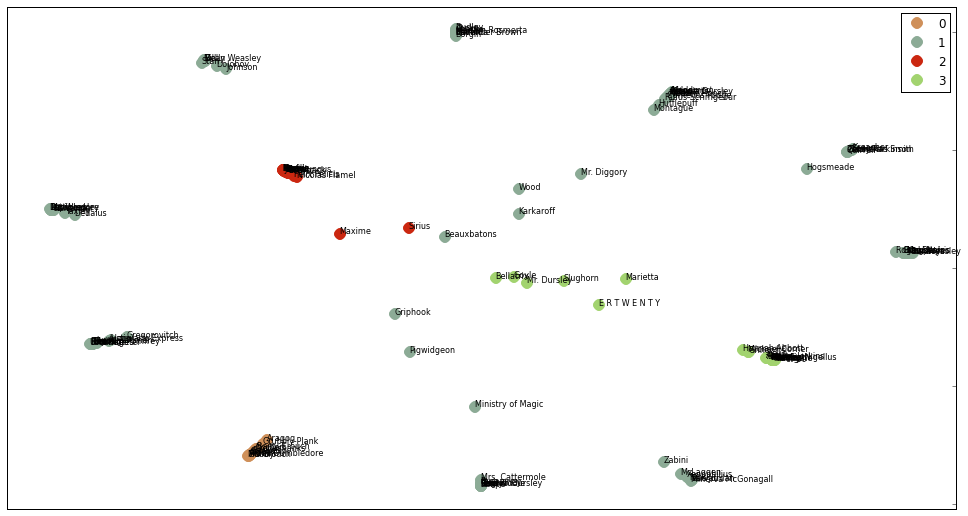

In [299]:
#The following is taken word for word from this tutorial: http://brandonrose.org/clustering

# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')

ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=8)  



plt.show() #show the plot


In [300]:
#uncomment the below to save the plot if need be
plt.savefig('clusters_small_noaxes.png', dpi=200)
plt.close()

#### Create and show dendrogram for the characters (again taken from the dude's tutorial)

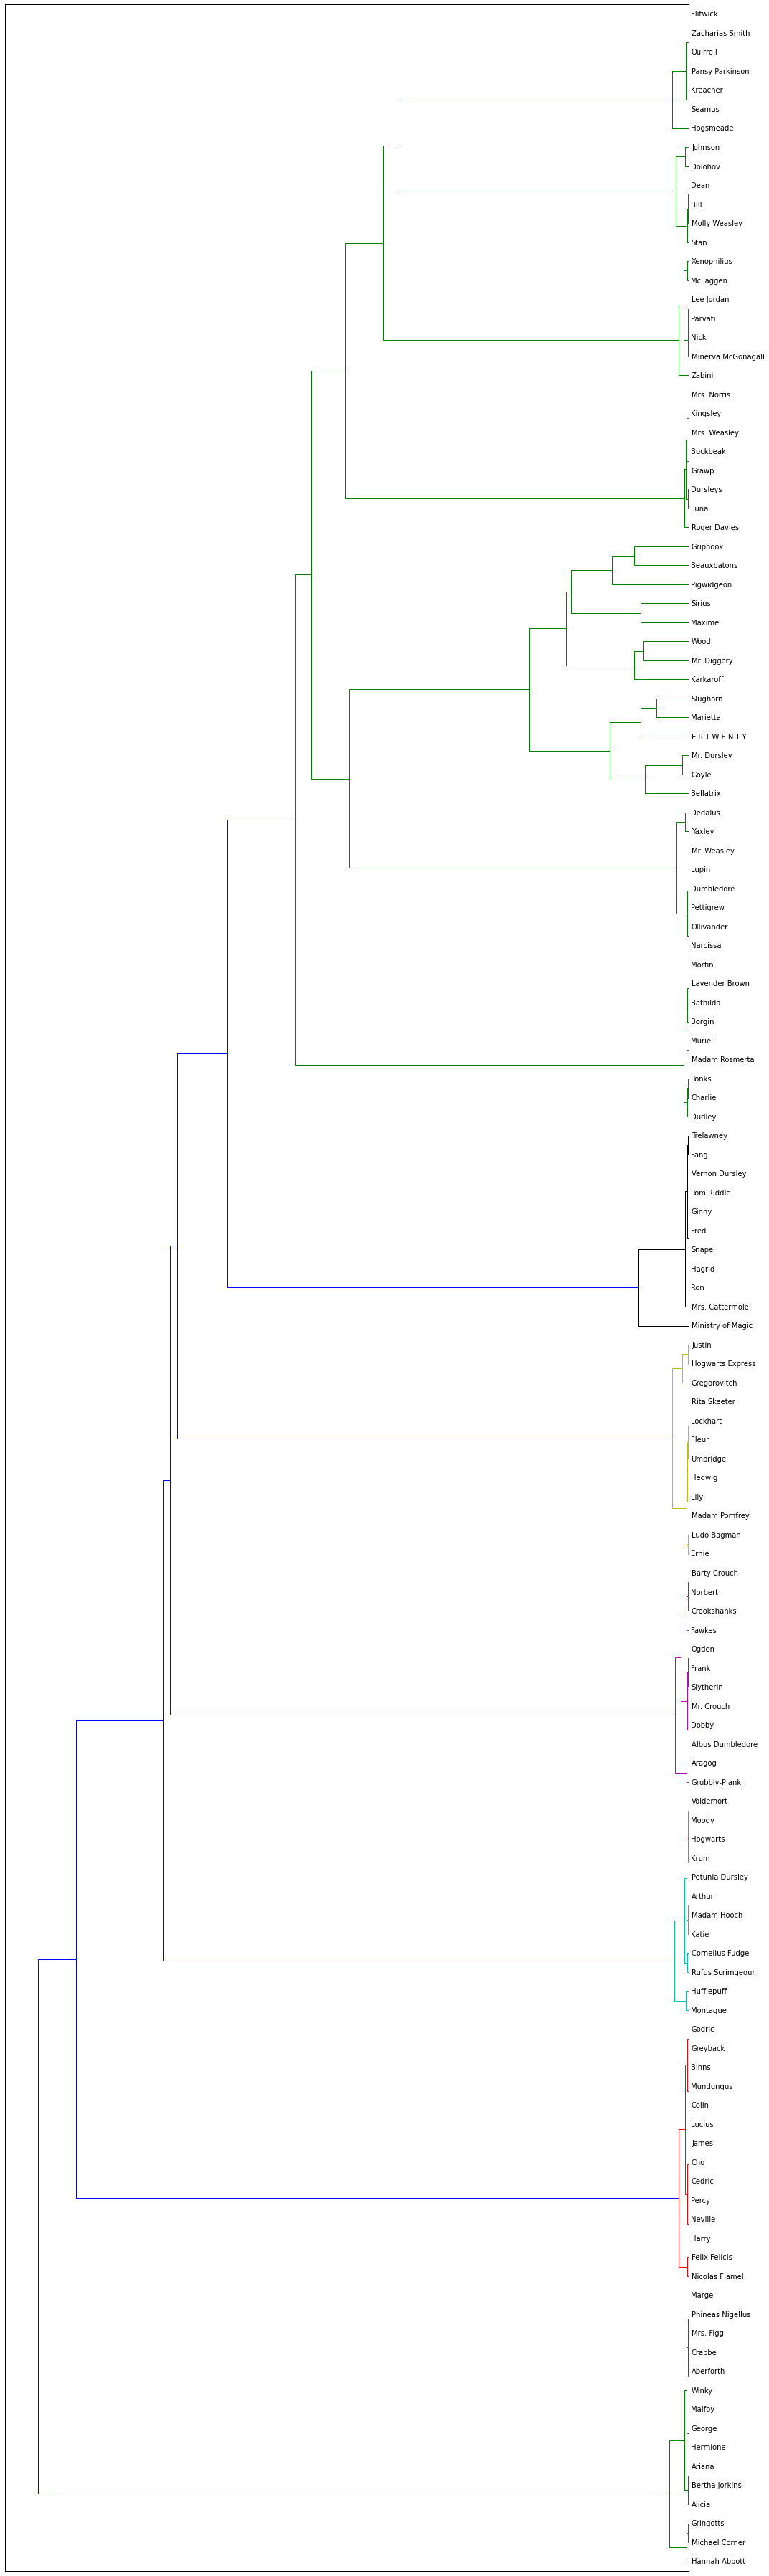

In [301]:
linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 50)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=charClusts['characters']);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters

## Supervised Learning with Topics

 What follows is an attempt to use the characters' generated topic probabilities as features for supervised learning (specifically logistic regression). Based on our ground truth labeled information, we will see whether the topic assignments are informative/useful for predicting these labels or not.

In [302]:
# load our labeled character data (choose one of our annotated character files)
import getVectors
getVectors = reload(getVectors)
# labels = ['Muggles', 'Hogwarts Students', 'Hogwarts Teachers', 'Ministry Officials', 
#           'Quidditch Players', 'Gryffindors', 'Ravenclaws', 'Hufflepuffs','Slytherins',
#          'Muggle-borns','Purebloods','Half-bloods','Humans','Part Humans', 'Non-Humans',
#          'Death Eaters', 'Order of the Phoenix', 'Dumbledores Army','Animagi', 'Parselmouths',
#          'Convicts','Weasleys','Dead','Bullies', 'Victims']
#(vectors, charlist) = getVectors.getVectors("cluster.txt")
labels = ['Protagonists', 'Antagonists', 'Neutral', 'Animals']
(vectors, charlist) = getVectors.getVectors("good_bad_labels.txt")
print charlist

['Lupin', 'Cho', 'Albus Dumbledore', 'Lily', 'Cedric', 'Harry Potter', 'Ron Weasley', 'Hermione Granger', 'Fred Weasley', 'George Weasley', 'Neville Longbottom', 'Ginny Weasley', 'Luna Lovegood', 'Dean Thomas', 'Oliver Wood', 'Rubeus Hagrid', 'Minerva McGonagall', 'Mad-Eye Moody', 'Arthur Weasley', 'Mr. Weasley', 'Tonks', 'Kingsley Shacklebolt', 'Viktor Krum', 'Sirius Black', 'Bill', 'Godric Gryffindor', 'Mrs. Weasley', 'Regulus', 'Fleur Delacour', 'Dobby', 'James Potter', 'Dudley', 'Malfoys', 'Yaxley', 'Goyle', 'Phineus Nigelus', 'Quirrell', 'Mr. Dursley', 'Mrs. Dursley', 'Aunt Marge', 'Draco Malfoy', 'Crabbe', 'Pansy Parkinson', 'Zacharias Smith', 'Montague', 'Severus Snape', 'Dolores Umbridge', 'Lucius', 'Cornelius Fudge', 'Barty Crouch', 'Peter Pettigrew', 'Voldemort', 'Bellatrix Lestrange', 'Salazar Slytherin', 'Narcissa Malfoy', 'Morfin', 'Antonin Dolohov', 'Rita Skeeter', 'Igor Karkaroff', 'Filch', 'Macnair', 'Travers', 'Fenrir Greyback', 'Kreacher', 'Griphook', 'Madam Hooch', '

In [303]:
# shuffle our samples
# combined = zip(charlist, vectors)
# random.shuffle(combined)
# charlist[:], vectors[:] = zip(*combined)

# just checking to make sure the vectors look right
# for i in range(len(vectors)):
#     print charlist[i]
#     print vectors[i]

In [304]:
# get a list of the indices for labeled characters that were recognized by book-nlp 
# (if they weren't returned in the character list, we can't classify them)
labeled = {}
j = 0 # index of character in labeled character list
for name in charlist:
    i = 0 # index of character in topic model vectors list
    found = False
    for name2 in names:
        #print name2
        if name.encode('UTF-8') in character_namelists[name2]:
            found = True
        elif not found == True:
            i+=1
    if found:
        # print name.encode('UTF-8')
        # tupe is topic vector index, charlist index
        labeled[name] = (j, i)
    #else:
        #print name.encode('UTF-8')
    j+=1
num_samples = len(labeled)
print num_samples

115


In [305]:
#print len(topic_matrix)
matrix = []
labeled_topic_matrix = []
labeled_chars = []
for char in labeled:
    #print char
    (charNameIndex, charTopicIndex) = labeled[char]
    print charNameIndex, charTopicIndex
    print charlist[charNameIndex]
    labeled_chars.append(charlist[charNameIndex])
    print vectors[charNameIndex]
    matrix.append(vectors[charNameIndex])
    print topic_matrix[charTopicIndex]              
    labeled_topic_matrix.append(topic_matrix[charTopicIndex])
    print

labeled_topic_matrix = np.array(labeled_topic_matrix) 
#print labeled_topic_matrix

labelmatrix = np.matrix(matrix)
#print labelmatrix

122 0
Madam Rosmerta
[0, 0, 1, 0]
[0.98793832422572014, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

11 109
Ginny Weasley
[1, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.99905496024531915]

116 86
Stan Shunpike
[0, 0, 1, 0]
[0, 0.99101287747649813, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

0 3
Lupin
[1, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0.99898146008072564, 0, 0]

31 4
Dudley
[0, 1, 0, 0]
[0.99823714345235171, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

1 5
Cho
[1, 0, 0, 0]
[0, 0, 0, 0, 0, 0.99493542429127568, 0, 0, 0, 0, 0, 0]

18 58
Arthur Weasley
[1, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0.98882099317307759, 0, 0, 0, 0]

84 119
Colin Creevey
[0, 0, 1, 0]
[0, 0, 0, 0, 0, 0.99181522905071873, 0, 0, 0, 0, 0, 0]

65 8
Madam Hooch
[0, 0, 1, 0]
[0, 0, 0, 0, 0, 0, 0, 0.98970010172747025, 0, 0, 0, 0]

91 51
Angelina Johnson
[0, 0, 1, 0]
[0, 0.94270717158435224, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

125 9
Nicolas Flamel
[0, 0, 1, 0]
[0, 0, 0, 0, 0, 0.96333210487595722, 0, 0, 0, 0, 0, 0]

88 10
Lavender Brown
[0, 0, 1, 0]
[0.98129205

In [306]:
from sklearn import linear_model
from sklearn import cross_validation


# choose the appropriate row to get your binary labels for feature i, then split it into a train/test set
# i.e. Muggles vs. not muggles, good guys vs. not good guys, etc.
for label in range(labelmatrix[0].size):
    print labels[label]
    #X_train, X_test, y_train, y_test = cross_validation.train_test_split(labeled_topic_matrix, labelmatrix[:,label], test_size=0.4, random_state=0)
    logreg = linear_model.LogisticRegression(C=1e5)
    # train
    #logreg.fit(X_train, y_train)
    #Z = logreg.predict(X_test)
    #print "accuracy: ", logreg.score(X_test, y_test)
    # print Z
    print "Accuracy:"
    accuracyScores = cross_validation.cross_val_score(logreg, labeled_topic_matrix,  np.ravel(labelmatrix[:,label].T), cv=2)
    print accuracyScores
    print "Precision:"
    precisionScores = cross_validation.cross_val_score(logreg, labeled_topic_matrix,  np.ravel(labelmatrix[:,label].T), cv=2, scoring = 'precision')
    print precisionScores
    print "Recall:"
    recallScores = cross_validation.cross_val_score(logreg, labeled_topic_matrix,  np.ravel(labelmatrix[:,label].T), cv=2, scoring = 'recall')
    print recallScores
    print

Protagonists
Accuracy:
[ 0.74137931  0.75438596]
Precision:
[ 0.5         0.53333333]
Recall:
[ 0.46666667  0.53333333]

Antagonists
Accuracy:
[ 0.77586207  0.77192982]
Precision:
[ 0.57142857  0.6       ]
Recall:
[ 0.28571429  0.21428571]

Neutral
Accuracy:
[ 0.65517241  0.63157895]
Precision:
[ 0.64285714  0.55555556]
Recall:
[ 0.375       0.43478261]

Animals
Accuracy:
[ 0.86206897  0.80701754]
Precision:
[ 0.  0.]
Recall:
[ 0.  0.]

